# Tutorial

(see also https://docs.dftk.org/dev/guide/tutorial)

DFTK is a Julia package for playing with plane-wave
density-functional theory algorithms. In its basic formulation it
solves periodic Kohn-Sham equations.

This document provides an overview of the structure of the code
and how to access basic information about calculations.
Basic familiarity with the concepts of plane-wave density functional theory
is assumed throughout.

!!! note "Convergence parameters in the documentation"
    We use rough parameters in order to be able
    to automatically generate this documentation very quickly.
    Therefore results are far from converged.
    Tighter thresholds and larger grids should be used for more realistic results.

For our discussion we will use the classic example of
computing the LDA ground state of the silicon crystal.
Performing such a calculation roughly proceeds in three steps.

In [1]:
using DFTK
using Plots

# 1. Define lattice and atomic positions
a = 10.26  # Silicon lattice constant in Bohr
lattice = a / 2 * [[0 1 1.];
                   [1 0 1.];
                   [1 1 0.]]

# Load HGH pseudopotential for Silicon
Si = ElementPsp(:Si, psp=load_psp("hgh/lda/Si-q4"))

# Specify type and positions of atoms
atoms = [Si => [ones(3)/8, -ones(3)/8]]

# 2. Select model and basis
model = model_LDA(lattice, atoms)
kgrid = [4, 4, 4]  # k-point grid (Regular Monkhorst-Pack grid)
Ecut = 7           # kinetic energy cutoff in Hartree
basis = PlaneWaveBasis(model, Ecut; kgrid=kgrid)

# 3. Run the SCF procedure to obtain the ground state
scfres = self_consistent_field(basis, tol=1e-8);

n     Energy            ρout-ρin   Eₙ₋₁-Eₙ    Diag
---   ---------------   --------   --------   ----
1     -7.898448896791   1.99e-01        NaN   4.1 
2     -7.902650118478   2.76e-02   4.20e-03   1.0 
3     -7.903243305114   5.16e-03   5.93e-04   1.1 
4     -7.903287993217   6.99e-04   4.47e-05   2.1 
5     -7.903289945908   2.16e-04   1.95e-06   2.3 
6     -7.903289963422   2.18e-05   1.75e-08   1.4 
7     -7.903289965049   2.03e-05   1.63e-09   2.3 


That's it! Now you can get various quantities from the result of the SCF.
For instance, the different components of the energy:

In [2]:
scfres.energies

Energy breakdown:
    Kinetic             3.1029900 
    AtomicLocal         -2.1959146
    AtomicNonlocal      1.7296352 
    Ewald               -8.4004648
    PspCorrection       -0.2948928
    Hartree             0.5523920 
    Xc                  -2.3970350

    total               -7.903289965049


Eigenvalues:

In [3]:
hcat(scfres.eigenvalues...)

7×8 Array{Float64,2}:
 -0.176439  -0.146911  -0.0905646   …  -0.100644   -0.0233384  -0.0177473
  0.261844   0.117595   0.00538932      0.0618524  -0.0233384  -0.0177472
  0.261845   0.233733   0.217468        0.12223     0.15619     0.118325
  0.261845   0.233733   0.217468        0.212857    0.156191    0.118326
  0.355279   0.335941   0.317934        0.351159    0.286302    0.417953
  0.355279   0.39059    0.385303    …   0.437749    0.286302    0.419087
  0.355308   0.39059    0.385304        0.450043    0.63012     0.444652

`eigenvalues` is an array (indexed by kpoints) of arrays (indexed by
eigenvalue number). The "splatting" operation `...` calls `hcat`
with all the inner arrays as arguments, which collects them into a
matrix.

The resulting matrix is 7 (number of computed eigenvalues) by 8
(number of kpoints). There are 7 eigenvalues per kpoint because
there are 4 occupied states in the system (4 valence electrons per
silicon atom, two atoms per unit cell, and paired spins), and the
eigensolver gives itself some breathing room by computing some extra
states (see `n_ep_extra` argument to `self_consistent_field`).

We can check the occupations:

In [4]:
hcat(scfres.occupation...)

7×8 Array{Float64,2}:
 2.0  2.0  2.0  2.0  2.0  2.0  2.0  2.0
 2.0  2.0  2.0  2.0  2.0  2.0  2.0  2.0
 2.0  2.0  2.0  2.0  2.0  2.0  2.0  2.0
 2.0  2.0  2.0  2.0  2.0  2.0  2.0  2.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0

And density:

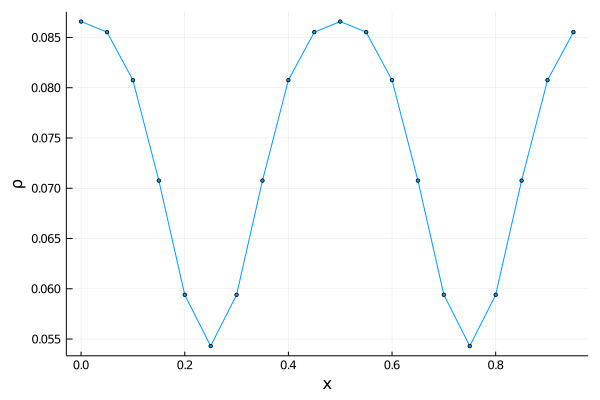

In [5]:
rvecs = collect(r_vectors(basis))[:, 1, 1]  # slice along the x axis
x = [r[1] for r in rvecs]                   # only keep the x coordinate
plot(x, scfres.ρ.real[:, 1, 1], label="", xlabel="x", ylabel="ρ", marker=2)

We can also perform various postprocessing steps:
for instance compute a band structure

Computing bands along kpath:
       Γ -> X -> W -> K -> Γ -> L -> U -> W -> L -> K  and  U -> X


Diagonalising Hamiltonian kblocks: 100%|████████████████| Time: 0:00:00


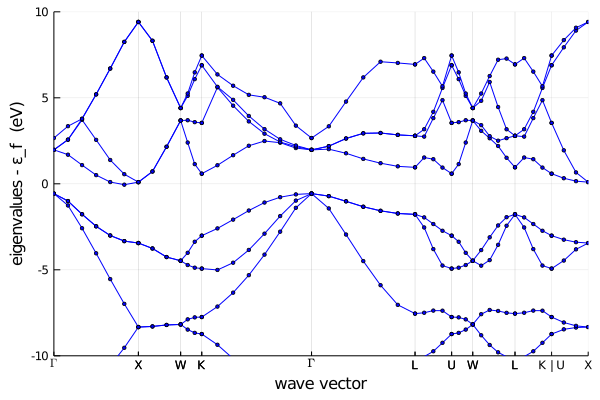

In [6]:
n_bands = 8
plot_bandstructure(scfres, n_bands, kline_density=5, unit=:eV)

or forces

In [7]:
forces(scfres)[1]  # Select silicon forces

2-element Array{StaticArrays.SArray{Tuple{3},Float64,1,3},1}:
 [-8.118426031882078e-7, -1.2490466220183713e-6, -3.7959940536667934e-7]
 [-1.066309782594629e-6, -1.0804165031451979e-6, -2.4002380547225516e-7]

The `[1]` extracts the forces for the first kind of atoms,
i.e. `Si` (silicon) in the setup of the `atoms` list of step 1 above.
As expected, they are almost zero in this highly symmetric configuration.

# Building complex structures with ASE
(see also https://docs.dftk.org/dev/examples/ase/)



Parameters of the calculation. Since this surface is far from easy to converge,
we made the problem simpler by choosing a smaller `Ecut` and smaller values
for `n_Si` and `n_vacuum`.
More interesting settings are `Ecut = 15` and `n_Si = n_vacuum = 20`.

In [8]:
miller = (1, 1, 0)   # Surface Miller indices
n_Si = 4             # Number of GaAs layers
n_vacuum = 4         # Number of vacuum layers
Ecut = 5             # Hartree
kgrid = (4, 4, 1);   # Monkhorst-Pack mesh

Use ASE to build the structure:

In [9]:
using PyCall

ase_build = pyimport("ase.build")
si = ase_build.bulk("Si")
surface = ase_build.surface(si, miller, n_Si, 0, periodic=true);

Get the amount of vacuum in Ångström we need to add

In [10]:
d_vacuum = maximum(maximum, surface.cell) / n_Si * n_vacuum
surface = ase_build.surface(si, miller, n_Si, d_vacuum, periodic=true);

Check what it looks like:

In [11]:
pyimport("ase.visualize").view(surface)

Use the `load_atoms` and `load_lattice` functions
to convert to DFTK datastructures.
These two functions not only support importing ASE atoms into DFTK,
but a few more third-party datastructures as well.
Typically the imported `atoms` use a bare Coulomb potential,
such that appropriate pseudopotentials need to be attached in a post-step:

In [12]:
using DFTK

atoms = load_atoms(surface)
atoms = [ElementPsp(el.symbol, psp=load_psp(el.symbol, functional="pbe")) => position
         for (el, position) in atoms]
lattice = load_lattice(surface);

We model this surface with (quite large a) temperature of 0.01 Hartree
to ease convergence. Try lowering the SCF convergence tolerance (`tol`
or the `temperature` to see the full challenge of this system.

In [13]:
model = model_DFT(lattice, atoms, [:gga_x_pbe, :gga_c_pbe],
                  temperature=0.001, smearing=DFTK.Smearing.Gaussian())
basis = PlaneWaveBasis(model, Ecut; kgrid=kgrid)

scfres = self_consistent_field(basis, tol=1e-6, mixing=RestaMixing(εr=12));

n     Free energy       ρout-ρin   Eₙ₋₁-Eₙ    Diag
---   ---------------   --------   --------   ----
1     -31.054687913998   3.68e-01        NaN   4.8 
2     -31.090754930286   1.05e-01   3.61e-02   1.1 
3     -31.094487610901   1.34e-02   3.73e-03   1.2 
4     -31.095599896476   5.45e-03   1.11e-03   3.2 
5     -31.095667404420   1.37e-03   6.75e-05   1.9 
6     -31.095677214737   6.67e-04   9.81e-06   2.4 
7     -31.095675571158   3.33e-04  -1.64e-06   2.7 
8     -31.095678936795   2.06e-04   3.37e-06   2.8 
9     -31.095679569748   1.62e-04   6.33e-07   3.0 


# Arbitrary floating-point types

(see also https://docs.dftk.org/dev/examples/arbitrary_floattype/)



In [14]:
using DFTK

# Setup silicon lattice
a = 10.263141334305942  # lattice constant in Bohr
lattice = a / 2 .* [[0 1 1.]; [1 0 1.]; [1 1 0.]]
Si = ElementPsp(:Si, psp=load_psp(:Si, functional="lda"))
atoms = [Si => [ones(3)/8, -ones(3)/8]]

# Cast to Float32, setup model and basis
model = model_DFT(Array{Float32}(lattice), atoms, [:lda_x, :lda_c_vwn])
Ecut = 7
basis = PlaneWaveBasis(model, Ecut, kgrid=[4, 4, 4])

# Run the SCF
scfres = self_consistent_field(basis, tol=1e-4);

n     Energy            ρout-ρin   Eₙ₋₁-Eₙ    Diag
---   ---------------   --------   --------   ----
1     -7.900842189789   1.99e-01        NaN   4.1 
2     -7.904989242554   2.75e-02   4.15e-03   1.0 
3     -7.905573844910   5.15e-03   5.85e-04   1.1 
4     -7.905618667603   7.24e-04   4.48e-05   2.0 


Computing bands along kpath:
       Γ -> X -> W -> K -> Γ -> L -> U -> W -> L -> K  and  U -> X


Diagonalising Hamiltonian kblocks: 100%|████████████████| Time: 0:00:00


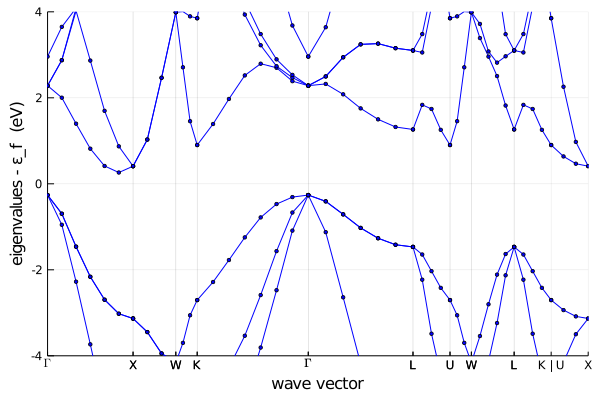

In [15]:
n_bands = 8
plot_bandstructure(scfres, n_bands, kline_density=5, unit=:eV)

In [16]:
forces(scfres)[1]

2-element Array{StaticArrays.SArray{Tuple{3},Float32,1,3},1}:
 [4.6831206f-5, 2.0978403f-5, 4.4164328f-5]
 [1.9081437f-5, 5.4098678f-6, 2.028232f-5]

# Custom models and solvers
(see https://docs.dftk.org/dev/examples/custom_solvers/)

In [17]:
using DFTK

# Setup silicon lattice
a = 10.263141334305942  # lattice constant in Bohr
lattice = a / 2 .* [[0 1 1.]; [1 0 1.]; [1 1 0.]]
Si = ElementPsp(:Si, psp=load_psp(:Si, functional="lda"))
atoms = [Si => [ones(3)/8, -ones(3)/8]]

# We build an LDA model, where the XC term is artificially scaled
# For precision we use Float32
terms_two_electron = [Hartree(),
                      Xc([:lda_x, :lda_c_vwn], scaling_factor=10)]

model = model_atomic(Array{Float32}(lattice), atoms,
                     extra_terms=terms_two_electron)
kgrid = [3, 3, 3]
Ecut = 5
basis = PlaneWaveBasis(model, Ecut; kgrid=kgrid);

We define our custom SCF solver: Simply a damped fixed-point solver:

In [18]:
function my_fp_solver(f, x0, max_iter; tol)
    T = eltype(x0)
    mixing_factor = T(.7)
    x = x0
    fx = f(x)
    for n = 1:max_iter
        inc = fx - x
        if norm(inc) < tol
            break
        end
        x = x + mixing_factor * inc
        fx = f(x)
    end
    (fixpoint=x, converged=norm(fx-x) < tol)
end

my_fp_solver (generic function with 1 method)

Our eigenvalue solver just forms the dense matrix and diagonalizes it explicitly (this only works for very small systems)

In [19]:
using LinearAlgebra

function my_eig_solver(A, X0; maxiter, tol, kwargs...)
    n = size(X0, 2)
    A = Array(A)
    E = eigen(Hermitian(A))
    λ = E.values[1:n]
    X = E.vectors[:, 1:n]
    (λ=λ, X=X, residual_norms=[], iterations=0, converged=true, n_matvec=0)
end

my_eig_solver (generic function with 1 method)

Finally we also define our custom mixing scheme. It will be a mixture of simple mixing (for the first 2 steps) and than default to Kerker mixing.

In [20]:
struct MyMixing
    α  # Damping parameter
end
MyMixing() = MyMixing(0.7)

function DFTK.mix(mixing::MyMixing, basis, ρin::RealFourierArray, ρout::RealFourierArray; n_iter, kwargs...)
    T = eltype(ρin)
    if n_iter <= 2
        # Just do simple mixing
        ρin + T(mixing.α) * (ρout - ρin)
    else
        # Use the KerkerMixing from DFTK
        DFTK.mix(KerkerMixing(α=mixing.α), basis, ρin, ρout; kwargs...)
    end
end

That's it! Now we just run the SCF with these solvers

In [21]:
scfres = self_consistent_field(basis;
                               tol=1e-8,
                               solver=my_fp_solver,
                               eigensolver=my_eig_solver,
                               mixing=MyMixing());

n     Energy            ρout-ρin   Eₙ₋₁-Eₙ    Diag
---   ---------------   --------   --------   ----
1     -32.000812530518   3.89e-01        NaN   0.0 
2     -33.390972137451   4.12e-01   1.39e+00   0.0 
3     -34.696094512939   4.46e-01   1.31e+00   0.0 
4     -35.582183837891   4.33e-01   8.86e-01   0.0 
5     -36.096714019775   3.68e-01   5.15e-01   0.0 
6     -36.356071472168   2.86e-01   2.59e-01   0.0 
7     -36.481628417969   2.11e-01   1.26e-01   0.0 
8     -36.542484283447   1.51e-01   6.09e-02   0.0 
9     -36.572319030762   1.07e-01   2.98e-02   0.0 
10    -36.587127685547   7.47e-02   1.48e-02   0.0 
11    -36.594539642334   5.20e-02   7.41e-03   0.0 
12    -36.598308563232   3.62e-02   3.77e-03   0.0 
13    -36.600219726563   2.51e-02   1.91e-03   0.0 
14    -36.601203918457   1.75e-02   9.84e-04   0.0 
15    -36.601707458496   1.22e-02   5.04e-04   0.0 
16    -36.601974487305   8.56e-03   2.67e-04   0.0 
17    -36.602119445801   6.01e-03   1.45e-04   0.0 
18    -36.6021